<a href="https://colab.research.google.com/github/arjan-hada/protein-design-vae/blob/main/protein_design_vae_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative unsupervised latent variable model for protein sequences: Variational Autoencoders


Imagine this: you're at the forefront of computational biology, wielding variational autoencoders (VAEs) to not just decipher but innovate the language of proteins. Each amino acid, a letter; each sequence, a life-defining sentence. Here’s the essence:

1. **Protein Encoder**: Like a diligent scholar, VAE learns from aligned protein sequences, and distills them into multidimensional latent space. This latent space captures the essential information about the protein sequence.

2. **Latent Space**: Within this latent realm, the VAE, akin to an explorer, identifies the underlying biological patterns in existing protein sequences.

3. **Decoder**: Given a point in the latent space identified as potentially interesting (e.g., representing a stable protein), the decoder translates this point back into a new protein sequence. This creates novel sequences with a higher likelihood of possessing the desired properties.

VAE marries the predictive power of machine learning with the creative potential of synthetic biology. It has the potential to accelerate the discovery of therapeutic proteins and enzymes with enhanced catalytic properties.

## Setup

In [1]:
!pip install seqlike biopython python-Levenshtein torcheval -q miniminiai datasets &> /dev/null

In [2]:
#Installing MAFFT using apt-get in quiet mode
!apt-get install -qq -y mafft &> /dev/null

In [3]:
#Checking that MAFFT was succesfully installed
#!mafft --help

In [4]:
# Import libraries
from seqlike import aaSeqLike
from seqlike.alphabets import AA
from Bio import SeqIO
import pandas as pd
import multiprocessing as mp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)
import fastcore.all as fc

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
import torch.optim as optim
from torch.optim import lr_scheduler
from miniminiai import *
from fastai.callback.training import GradientClip
from functools import partial

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [5]:
import random
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [6]:
torch.manual_seed(1)
set_seed(42)

In [7]:
!mkdir -p data

## The data: Multiple Sequence Alignment

#### Train and eval sequence

In [8]:
!wget -O data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta https://raw.githubusercontent.com/arjan-hada/protein-design-vae/main/data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta

--2024-08-14 19:08:27--  https://raw.githubusercontent.com/arjan-hada/protein-design-vae/main/data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1296686 (1.2M) [text/plain]
Saving to: ‘data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta’

data/tr-B5LY47-B5LY 100%[===================>]   1.24M  --.-KB/s    in 0.008s  

2024-08-14 19:08:27 (146 MB/s) - ‘data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta’ saved [1296686/1296686]



In [9]:
!head data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta

>tr|B5LY47|B5LY47_ECOLX Beta-lactamase (Fragment) OS=Escherichia coli OX=562 PE=1 SV=1
------AACIPLLL-GSAPLYA-QTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRG
DERFPMCSTSKVMAAAAVLKQS--ETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLA
ELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDT
TTPRAMAQTLRQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGGY
GTTNDIAVIWPQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
>gb|QGJ84174.1| CTX-M family beta-lactamase, partial [Escherichia coli] >gb|QGJ84176.1| CTX-M family beta-lactamase, partial [Escherichia coli] >gb|QGJ84177.1| CTX-M family beta-lactamase, partial [Escherichia coli]
------AACIPLLL-GSAPLYA-QTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRG
DERFPMCSTSKVMAAAAVLKQS--ETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLA
ELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDT


In [10]:
input_file = "data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_2.fasta"

In [11]:
seqs = pd.Series([aaSeqLike(s, alphabet=AA)
for s in SeqIO.parse(input_file, "fasta")])
seqs = pd.Series([x for x in seqs if "B" not in x and "X" not in x])
len(seqs)

2943

In [12]:
seqs[:10].seq.plot()

GridPlot(id='p1074', ...)

In [13]:
print(seqs.seq.as_alignment().get_alignment_length())

288


We are starting from a set of meaningful protein sequences from multiple sequence alignment, and we hope to train a model to reproduce them with some novelty. Leveraging Multiple Sequence Alignments (MSAs) for generative model training offers advantages:

1. **Handling Sequence Length Variation:** MSAs effectively address the challenge of **sequences with different lengths**. Gap characters within the alignment accommodate variations, allowing the model to learn from sequences of varying sizes.

2. **Capturing Evolutionary Relationships:** MSAs go beyond simply aligning sequences. They capture the **evolutionary relationships** between a group of protein sequences. This is achieved by:

    - **Explicit Information:** MSAs explicitly capture **position-wise amino acid frequencies**. This reveals how **conserved** (important) each residue appears to be at a specific position in the protein.

    - **Implicit Information:** While not directly encoded, MSAs also implicitly capture **correlations between positions**. These correlations represent the interdependence of amino acids at different locations within the protein structure, a key aspect not captured by models that solely rely on position-wise frequencies.

By incorporating both explicit and implicit information from MSAs, generative models can learn more nuanced relationships between protein sequences and generate novel sequences that are not only structurally feasible but also potentially retain important functional features.

### Test sequence

Completely held out from training.

In [14]:
!wget -O data/6BU3_A_ESMIF1_0.1_500_multichain.fasta https://raw.githubusercontent.com/arjan-hada/protein-design-vae/main/data/6BU3_A_ESMIF1_0.1_500_multichain.fasta

--2024-08-14 19:08:31--  https://raw.githubusercontent.com/arjan-hada/protein-design-vae/main/data/6BU3_A_ESMIF1_0.1_500_multichain.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139892 (137K) [text/plain]
Saving to: ‘data/6BU3_A_ESMIF1_0.1_500_multichain.fasta’

data/6BU3_A_ESMIF1_ 100%[===================>] 136.61K  --.-KB/s    in 0.002s  

2024-08-14 19:08:31 (55.6 MB/s) - ‘data/6BU3_A_ESMIF1_0.1_500_multichain.fasta’ saved [139892/139892]



In [15]:
fname_sampled_seqs_multich = "data/6BU3_A_ESMIF1_0.1_500_multichain.fasta"

In [16]:
seqs_test = pd.Series([aaSeqLike(s, alphabet=AA)
for s in SeqIO.parse(fname_sampled_seqs_multich, "fasta")])
seqs_test = pd.Series([x for x in seqs_test if "B" not in x and "X" not in x])
len(seqs_test)

500

In [17]:
seqs_all = pd.concat([seqs, seqs_test], ignore_index=True)
len(seqs_all)

3443

In [18]:
seqs_all_aligned = seqs_all.seq.align()
seqs_all_aligned = pd.Series([aaSeqLike(s, alphabet=AA) for s in seqs_all_aligned])
print(seqs_all_aligned.seq.as_alignment().get_alignment_length())

288


In [19]:
#seqs_all_aligned.seq.plot(boxheight=1, use_bokeh=False, show_grouping=True)

In [20]:
seqs_all_aligned[:10].seq.plot()

GridPlot(id='p1154', ...)

In [21]:
seqs_all_aligned[-10:].seq.plot()

GridPlot(id='p1234', ...)

## Datasets and Dataloaders

In [22]:
from seqlike.encoders import onehot_encoder_from_alphabet
STANDARD_AA = '-ACDEFGHIKLMNPQRSTVWY'

class ProteinDataset(Dataset):
    """Creates a custom dataset to handle protein sequences represented as SeqLikes."""

    def __init__(self, seq_series):
        self.seq_series = seq_series
        self.encoder = onehot_encoder_from_alphabet(STANDARD_AA)
        self.xl = torch.tensor(seq_series.seq.to_onehot(encoder=self.encoder)).float().unsqueeze(1)
        self.yl = self.xl.clone()

    def __len__(self):
        """Returns the number of sequences in the dataset."""
        return len(self.seq_series)

    def __getitem__(self, index):
        """Returns the sequence at the specified index."""
        return self.xl[index, :], self.yl[index, :]

In [23]:
ds= ProteinDataset(seqs_all_aligned)
print(len(ds))

3443


Notice that `class ProteinDataset(Dataset)` utilizes the input protein sequence as both the input and target during training.

In [24]:
N = len(ds)
test_ds = Subset(ds, range(N - 500, N)) #last 500 seqs as test
remaining_ds = Subset(ds, range(N - 500))

In [25]:
train_size = int((N - 500) * 0.9)
val_size = N - 500 - train_size

train_ds, val_ds = random_split(remaining_ds, [train_size, val_size])

bs = 128
train_dl, val_dl = get_dls(train_ds, val_ds, bs=bs)

# Turn it into dls
dls = DataLoaders(train_dl, val_dl)

In [26]:
# Look at the data
xb, yb = next(iter(dls.train))
print(xb.shape)
print(yb.shape)
print(yb[0])

torch.Size([128, 1, 288, 21])
torch.Size([128, 1, 288, 21])
tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


## Model

Our model is a Variational Autoencoder (VAE) for protein sequence design. The VAE operates by first encoding an input protein sequence into a lower-dimensional latent representation, denoted as 'z'. This 'z' is not a single value, but rather a pair of vectors: the mean and standard deviation of a normal distribution. This approach allows the model to capture the essential features of the protein sequence in a compressed format while also accounting for the inherent variability observed in protein sequences. Subsequently, the VAE can sample from this learned distribution to generate new protein sequences. This sampling process enables the model to create novel protein sequences that share similar characteristics with the training data. For a tutorial on VAE see [this video](https://www.youtube.com/watch?v=9zKuYvjFFS8).

**Walks through different steps as I prototype the code, rather than final consolidated implementation.**

### Encoder

In [27]:
aln_len = xb.shape[-2]
alphabet_sz = xb.shape[-1]
ni,nh1,nh2,nh3,nl = 1, 256, 192, 128, 128

In [28]:
def enc_conv(ni, nf, norm=nn.BatchNorm2d, act=nn.SiLU):
    layers = nn.Sequential(nn.Conv2d(ni, nf, kernel_size=(3, 3),
                                     stride=(2, 1),
                                     padding=1,
                                     dilation=1))
    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return layers

In [29]:
out1 = enc_conv(ni, nh1)(xb)
print(out1.shape)
out2 = enc_conv(nh1, nh2)(out1)
print(out2.shape)
out3 = enc_conv(nh2, nh3)(out2)
print(out3.shape)
out4 = nn.Flatten()(out3)
print(out4.shape)

torch.Size([128, 256, 144, 21])
torch.Size([128, 192, 72, 21])
torch.Size([128, 128, 36, 21])
torch.Size([128, 96768])


In [30]:
def eff_seq_len(seq_len_in, n, kernel_size, stride, padding, dilation):
    """
    Calculate the effective sequence length after convolution.
    """

    seq_lens = []  # Store heights after each convolution
    seq_len_curr = seq_len_in

    for _ in range(n):
        seq_len_curr = ((seq_len_curr + 2*padding - dilation*(kernel_size - 1) - 1) // stride) + 1
        seq_lens.append(seq_len_curr)

    return seq_lens

In [31]:
eff_seq_lens = eff_seq_len(aln_len, 3, 3, 2, 1, 1)
eff_seq_lens

[144, 72, 36]

In [32]:
def lin(ni, nf, act=nn.SiLU, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    return layers

In [33]:
class VAEEncoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.convs = nn.Sequential(
            enc_conv(ni , nh1),
            enc_conv(nh1, nh2),
            enc_conv(nh2, nh3),
            nn.Flatten())

        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz
        self.fc_mu = lin(encoded_sz, nl, act=None)
        self.fc_logvar = lin(encoded_sz, nl, act=None)

    def forward(self, x):
        x = self.convs(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [34]:
encoder = VAEEncoder()
mu, logvar = encoder(xb)
mu.shape, logvar.shape

(torch.Size([128, 128]), torch.Size([128, 128]))

### Decoder

In [35]:
def decode_conv(ni, nf, ht_pad=0, norm=nn.BatchNorm2d, act=nn.SiLU):
    layers = layers = [nn.Upsample(scale_factor=(2,1), mode='nearest'),
              nn.Conv2d(ni, nf, kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=1,
                        dilation=1)]

    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return nn.Sequential(*layers)

In [36]:
out1 = lin(nl, nh3 * eff_seq_lens[-1] * alphabet_sz)(mu)
print(out1.shape)
out2 = nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz))(out1)
print(out2.shape)
out3 = decode_conv(nh3, nh2)(out2)
print(out3.shape)
out4 = decode_conv(nh2, nh1)(out3)
print(out4.shape)
out5 = decode_conv(nh1, ni, norm=None, act=None)(out4)
print(out5.shape)
out = nn.Softmax(dim=3)(out5)
print(out5.shape)

torch.Size([128, 96768])
torch.Size([128, 128, 36, 21])
torch.Size([128, 192, 72, 21])
torch.Size([128, 256, 144, 21])
torch.Size([128, 1, 288, 21])
torch.Size([128, 1, 288, 21])


In [37]:
class VAEDecoder(nn.Module):
    """Decoder network for VAE protein sequence design."""

    def __init__(self):
        super().__init__()

        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz

        self.layers = nn.Sequential(
            lin(nl, encoded_sz),
            nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz)),
            decode_conv(nh3, nh2),
            decode_conv(nh2, nh1),
            decode_conv(nh1, ni, norm=None, act=None),
            #nn.Softmax(dim=3)
            )

    def forward(self, z):
        x = self.layers(z)
        return x

In [38]:
decoder = VAEDecoder()
decoder(mu).shape

torch.Size([128, 1, 288, 21])

### Kaiming (He) initialization

In [39]:
def init_weights(m, leaky=0.):
    """
    Initializes weights of convolutional and linear layers using Kaiming/He normalization.

    Parameters:
    - m: A module or layer of a PyTorch model.
    - leaky: The negative slope of the leaky ReLU activation applied after the layer.
             This parameter is used to adjust the Kaiming initialization accordingly.
             For regular ReLU, keep it at 0. For leaky ReLU, set it to the value of the negative slope.
    """
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

Kaiming (He) initialization strategy designed to **preserve the variance of the inputs** through the layers of the network,
a property that is beneficial for maintaining effective gradient flow during training.

In [40]:
iw = partial(init_weights, leaky=0.2)

### Variational AutoEncoder (VAE)

In [41]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        iw(self)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) #convert logvar to std dev
        eps = torch.randn_like(std) # samples a random noise vector (eps) from a standard normal distribution that matches the shape of std
        return mu + eps * std # random noise vector is scaled by the standard deviation and then shifted by the mu

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

The VAE's `forward` method encodes an input protein, samples a latent representation ('z'), and decodes it back to a new protein. During training, we return both the reconstructed protein and the latent distribution's mean and standard deviation for loss calculation.

In [42]:
m = VAE()
m

VAE(
  (encoder): VAEEncoder(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (2): Sequential(
        (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (3): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=96768, out_features=128, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=96768, out_features=128, bias=True)
    )
  )
  (decoder): VAED

In [43]:
result = m(xb)

reconstruction, mean, logvar = result

reconstruction.shape, mean.shape, logvar.shape

(torch.Size([128, 1, 288, 21]), torch.Size([128, 128]), torch.Size([128, 128]))

## The Learner

### VAE Loss

We have two terms in our VAE loss function. Reconstruction loss measures how well the model has reconstructed the protein from 'z', and the KL Divergence is there to force the VAE to learn a distribution that is close to a standard normal distribution. This is a regularizer that helps the model to learn meaningful representations, so that (if all goes well) we can later use it to generate new proteins.

$$
\text{VAE Loss} = \text{Reconstruction Loss} + \text{KL Divergence Loss}
$$


The terms "ELBO" (Evidence Lower Bound) and "VAE loss" are closely related in the context of Variational Autoencoders (VAEs), but they are used to describe slightly different concepts. Both ELBO and VAE loss consist of the same components (reconstruction error and KL divergence); however, they differ in their optimization direction. The ELBO is maximized, whereas the VAE loss is minimized.

**ELBO: Evidence Lower Bound**

The ELBO is a statistical construct used in variational inference to approximate the intractable true posterior distribution \( p(z|x) \) of latent variables \( z \) given observed data \( x \). It is formulated to maximize the likelihood of the data while keeping the model's inferred latent distributions close to a prior distribution. The ELBO is given by:

$$
\text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z))
$$

Where:
- $\mathbb{E}_{q(z|x)}[\log p(x|z)]$ is the expected log-likelihood of the observed data under the model, encouraging accurate reconstruction of the data.
- $D_{KL}(q(z|x) \| p(z))$ is the KL divergence between the variational approximation of the posterior $q(z|x)$ and the prior distribution $p(z)$, promoting regularization of the latent space.

**VAE Loss**

The VAE loss, on the other hand, is the specific formulation used in training VAE models, which typically aims to minimize a function that is, in essence, the negative of the ELBO. Thus, the VAE loss can be expressed as:

$$
\text{VAE Loss} = -\text{ELBO} = -(\mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z)))
$$

This rephrasing leads to:

$$
\text{VAE Loss} = D_{KL}(q(z|x) \| p(z)) - \mathbb{E}_{q(z|x)}[\log p(x|z)]
$$

Where:
- The negative sign in front of the expected log-likelihood (reconstruction loss) arises from converting the maximization of ELBO into a minimization problem.
- **Reconstruction Loss** can be computed using various methods, such as mean squared error (MSE) or cross-entropy, depending on the nature of the data

**Example of Cross-Entropy as Reconstruction Loss**

If the reconstruction loss is computed using cross-entropy, and you are working with data where this metric is appropriate (like images with pixel values treated as probabilities), the reconstruction loss component (using cross-entropy) would be:

$$
\text{Cross-Entropy Loss} = -\sum_{i=1}^N x_i \log(\hat{x}_i)
$$

Here, $x_i$ is the true pixel value, and $\hat{x}_i$ is the reconstructed pixel value from the VAE. The negative sign is used because cross-entropy inherently measures the divergence, and we use negative log probabilities in its computation.

In [44]:
def kld_loss(inp, x):  # KL Divergence
    x_hat, mu, logvar = inp
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

def cross_entropy_loss(inp, x):  # Reconstruction loss
    x_indices = torch.argmax(x, dim=-1).squeeze(1) # Converts to class indices and removes the singleton channel dimension
    logits_reshaped = inp[0].float().squeeze(1) ## Removes the singleton channel dimension, resulting in [bs, seq_len, alphabet_sz]
    return F.cross_entropy(logits_reshaped.view(-1, alphabet_sz), x_indices.view(-1),
                           reduction='mean')

def vae_loss(inp, x): return kld_loss(inp, x) + cross_entropy_loss(inp, x)

In [45]:
vae_loss(result, xb)

tensor(3.1804, grad_fn=<AddBackward0>)

In [46]:
cross_entropy_loss(result, xb)

tensor(3.0857, grad_fn=<NllLossBackward0>)

In [47]:
kld_loss(result, xb)

tensor(0.0946, grad_fn=<MulBackward0>)

In [48]:
class FuncMetric(Mean):
    """Compute the mean of any function (`fn`) applied to inputs and targets over all updates"""
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [49]:
from collections import defaultdict, deque

class ExtendedMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
        # Initialize storage for metrics' history across epochs
        self.metrics_history = defaultdict(lambda: {'train': deque(), 'eval': deque()})

    def after_epoch(self, learn):
        # Capture and store the current epoch's metrics for both training and evaluation
        phase = 'train' if learn.model.training else 'eval'
        current_metrics = {k: v.compute() for k, v in self.all_metrics.items()}
        for name, value in current_metrics.items():
            self.metrics_history[name][phase].append(value)

        # Call the original logging mechanism
        super().after_epoch(learn)

    def plot_metrics(self):
        # Plot the stored metrics history for both training and evaluation
        for metric_name, phase_data in self.metrics_history.items():
            plt.figure(figsize=(7, 4))
            for phase, values in phase_data.items():
                epochs = range(1, len(values) + 1)
                plt.plot(epochs, values, label=f'{phase} {metric_name}')
            plt.title(f'{metric_name} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name)
            plt.legend()
            plt.grid(True)
            plt.show()

In [50]:
metrics = ExtendedMetricsCB(kld=FuncMetric(kld_loss),
                    cross_entropy=FuncMetric(cross_entropy_loss))

# Define the optimizer
#opt_func = partial(optim.Adam, eps=1e-5)

### Functions for training quality plots

Functions required to define `Activationstats` callback that record the mean, standard deviation, and histogram of activations of every trainable layer. This allows us to look inside our models while they're training. Think of this as quality plots from training process we can use to find ways to make our model train better.

Code from: https://github.com/fastai/minai/blob/main/core.ipynb

In [51]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp).float()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [52]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [53]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

In [54]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [55]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [56]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [57]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')


    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

### Learning rate finder

`Learner` class from super-duper awesome [fastai](https://github.com/fastai/course22p2/blob/master/nbs/29_vae.ipynb).

In [58]:
torch.cuda.is_available()

True

In [59]:
torch.backends.cudnn.enabled

True

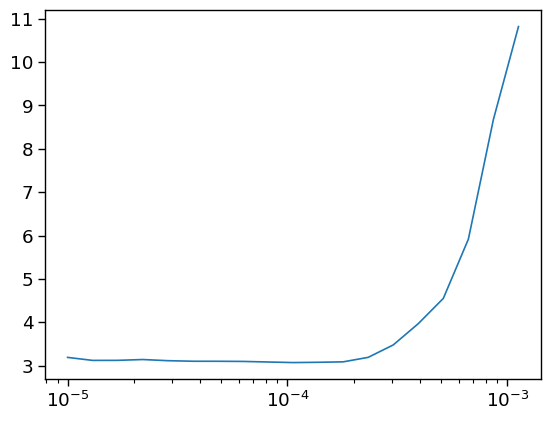

In [60]:
lrf_cbs = [TrainCB(), DeviceCB(), metrics]
model = VAE()
learn = Learner(model, dls, vae_loss, lr=0.1, cbs=lrf_cbs, opt_func=optim.AdamW)
# lr_find does *not* reset model, so recreate it afterwards
learn.lr_find()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [61]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

In [62]:
lr = 1e-4
epochs = 100
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
astats = ActivationStats(fc.risinstance(nn.Conv2d))


cbs = [DeviceCB(), # Handles making sure data and model are on the right device
       ProgressCB(plot=True), # Displays metrics and loss during training
       metrics, # Keep track of any relevant metrics
       BatchSchedCB(sched),
       GradientClip, # Prevents exploding gradients
       MixedPrecision(),
       rec,
       astats] # Keep track of metrics

# Define the model
model = VAE()
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=optim.AdamW)

kld,cross_entropy,loss,epoch,train
0.045,3.057,3.103,0,train
0.004,3.044,3.048,0,eval
0.035,3.024,3.059,1,train
0.017,3.025,3.041,1,eval
0.048,2.975,3.023,2,train
0.053,2.945,2.999,2,eval
0.086,2.879,2.966,3,train
0.119,2.803,2.921,3,eval
0.166,2.673,2.841,4,train
0.214,2.517,2.728,4,eval


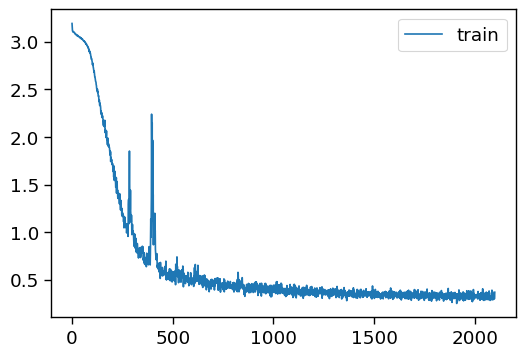

In [63]:
learn.fit(epochs)

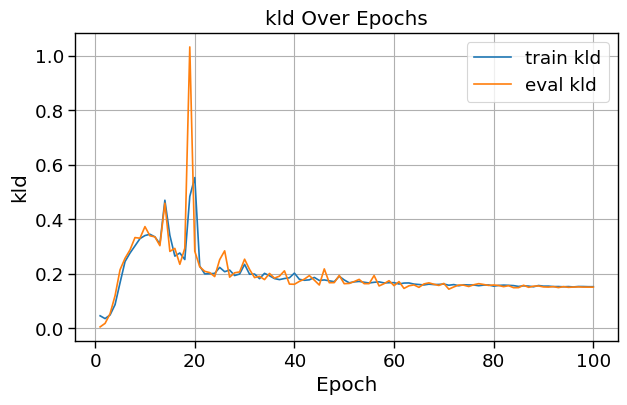

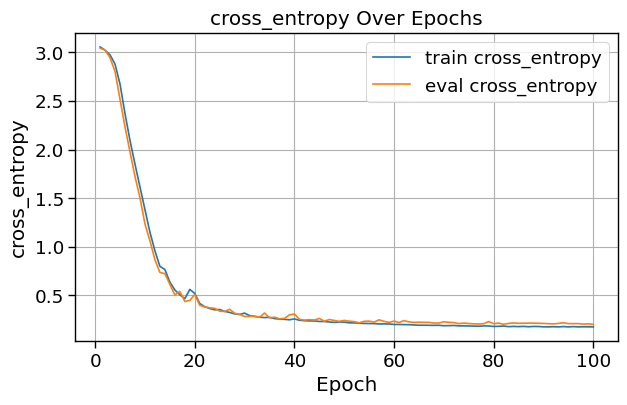

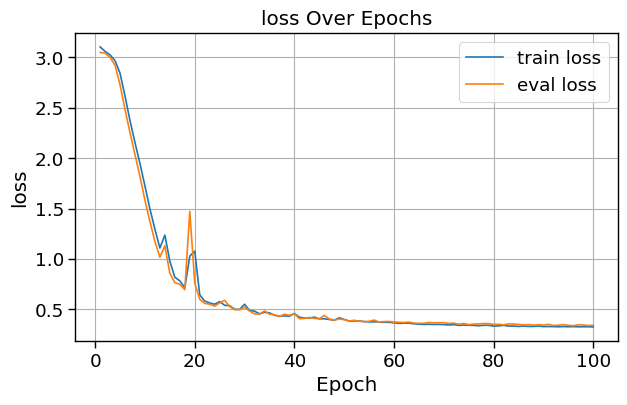

In [64]:
metrics.plot_metrics()

View the learning rate and momentum throughout training.

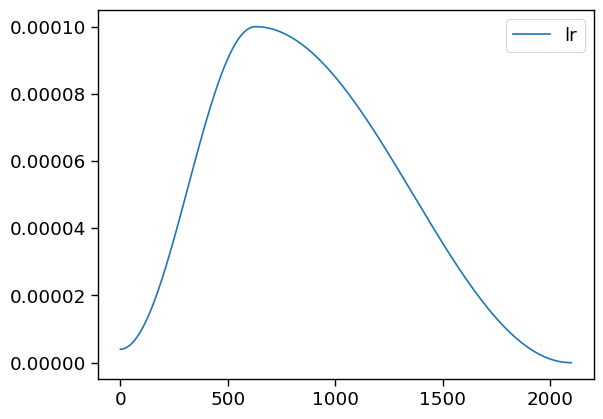

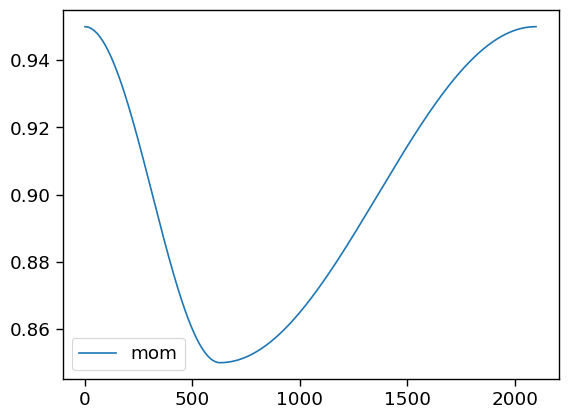

In [65]:
rec.plot()

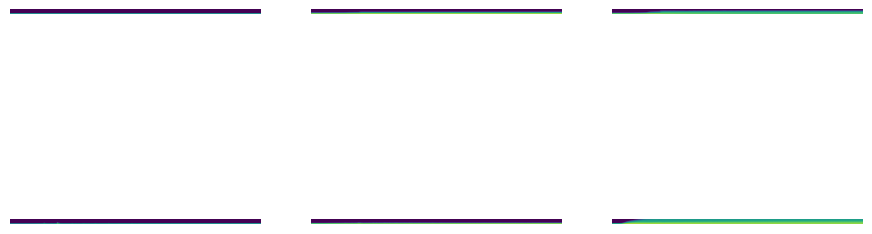

In [66]:
plt.rc('image', cmap='viridis')
astats.color_dim()

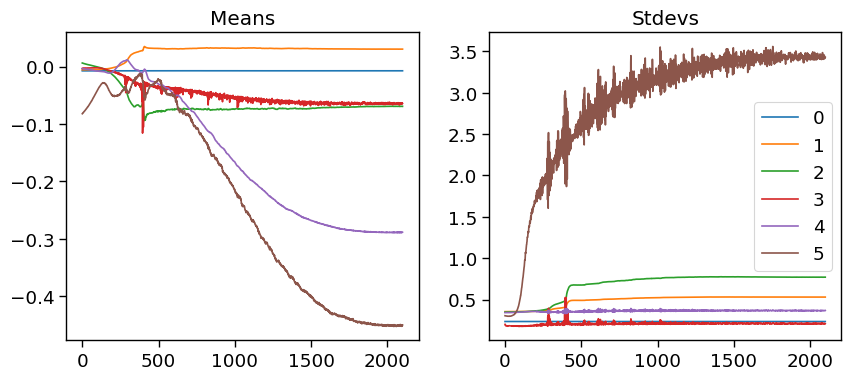

In [67]:
astats.plot_stats()

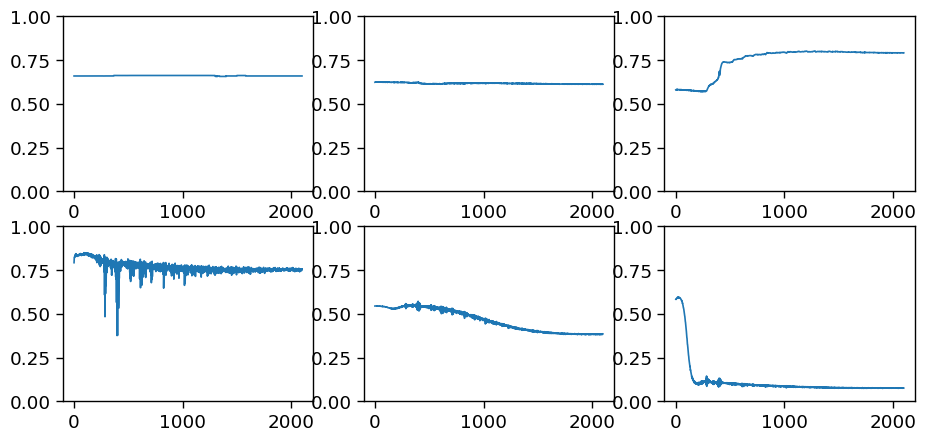

In [68]:
astats.dead_chart()

## VAE Reconstructions

### Reconstruction of query sequence

In [69]:
# query sequence
b5ly47 = ProteinDataset(seqs_all_aligned.iloc[0:1])
b5ly47_tensor, _ = b5ly47[0]
b5ly47_tensor = b5ly47_tensor.unsqueeze(0)

In [70]:
# perform forward pass through model without computing gradients,
# retrieve the model's outputs
with torch.no_grad(): recon_b5ly47, mu_b5ly47, logvar_b5ly47 = to_cpu(model(b5ly47_tensor.cuda()))
recon_b5ly47 = recon_b5ly47.float()

In [71]:
# Calculate the sequence recovery of query sequence
b5ly47_seq = aaSeqLike(b5ly47_tensor.cpu().squeeze().detach().numpy(),
                       alphabet=STANDARD_AA)
b5ly47_recon_seq = aaSeqLike(recon_b5ly47.cpu().squeeze().detach().numpy(),
                             alphabet=STANDARD_AA)
recovery = np.mean([(a==b) for a, b in zip(b5ly47_seq, b5ly47_recon_seq)])
recovery

0.9965277777777778

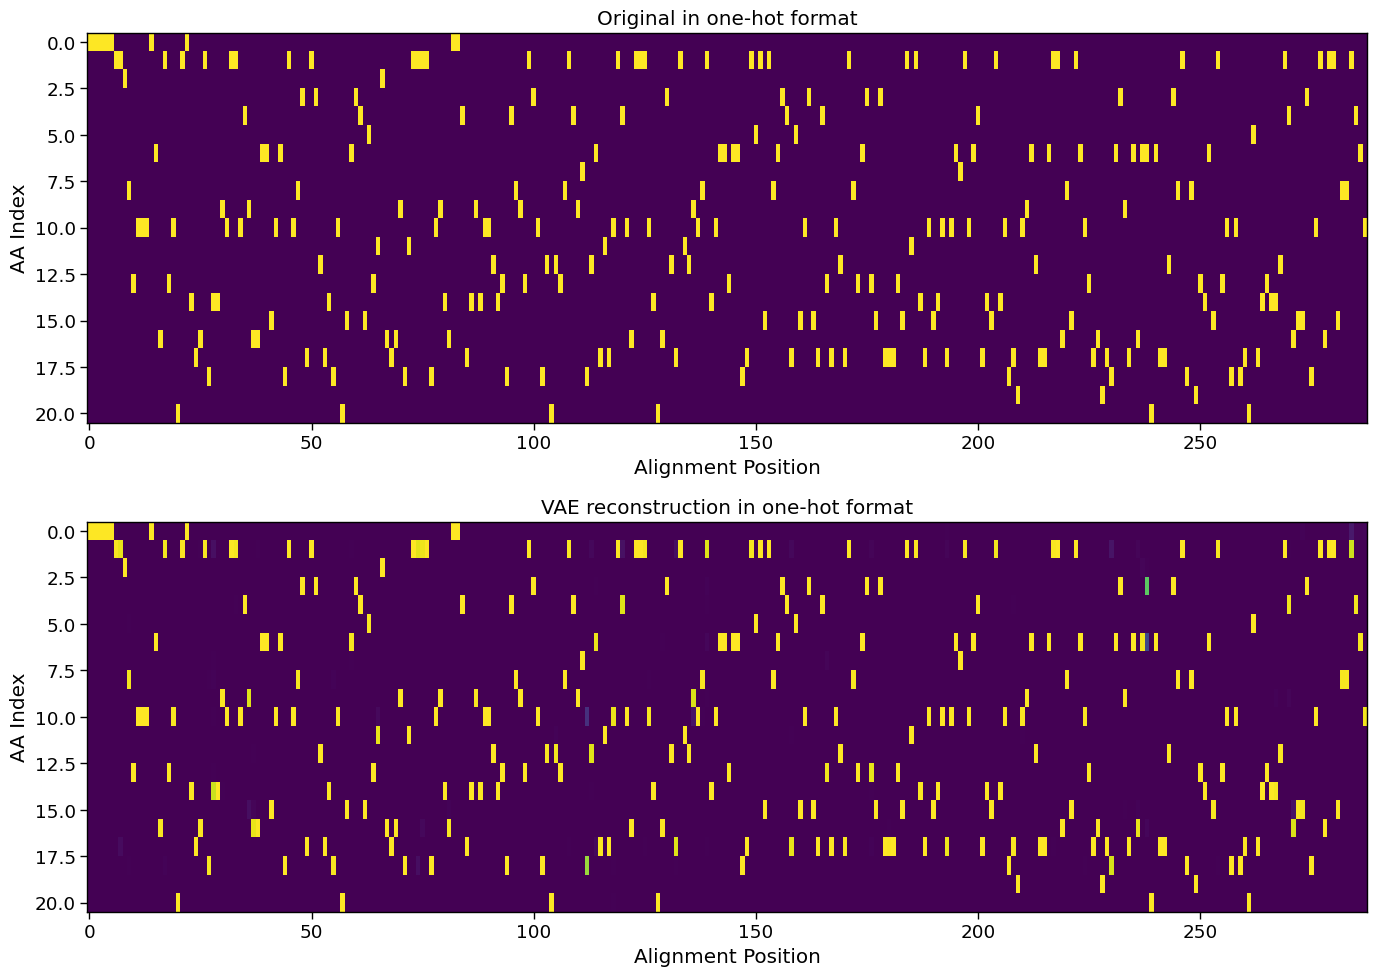

In [72]:
plt.figure(figsize=(14, 10))

# Top plot for original sequence
plt.subplot(2, 1, 1)
plt.imshow(b5ly47_tensor.cpu().squeeze().T, vmax=1, vmin=0)
plt.axis("tight")
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("Original in one-hot format")

# Bottom plot for VAE reconstruction
plt.subplot(2, 1, 2)
plt.imshow(F.softmax(recon_b5ly47, dim=-1).cpu().squeeze().T, vmax=1, vmin=0)
plt.axis("tight")
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("VAE reconstruction in one-hot format")

plt.tight_layout()
plt.show();

### Example reconstruction on a training batch

In [73]:
# perform forward pass through model without computing gradients,
# retrieve the model's outputs
with torch.no_grad(): recon,mu,logvar = to_cpu(model(xb.cuda())) #xb is one batch of train samples
recon = recon.float()

#### Sequence recovery

In [74]:
in_seqs = pd.Series([aaSeqLike(xb[i].cpu().squeeze().detach().numpy(),
                               alphabet=STANDARD_AA)
for i in range(xb.shape[0])])

In [75]:
# Convert logits to probabilities
recon_probs = F.softmax(recon, dim=-1)

In [76]:
out_seqs = pd.Series([aaSeqLike(recon_probs[i].cpu().squeeze().detach().numpy(),
                                alphabet=STANDARD_AA)
for i in range(recon_probs.shape[0])])

In [77]:
# Mean recovery of one sequence
print(in_seqs[0].seq)
print(out_seqs[0].seq)
print(np.mean([(a==b) for a, b in zip(in_seqs[0], out_seqs[0])]))

-------ATVTLLL-GSVPLYA-QTADVQQKLAELERQSGGRLGVALINTADNSQILYRADERFAMCSTSKVMAAAAVLKKS--ESEPNLLNQRVEIKKSDLVNYNPIAEKHVNGTMSMAELSAAALQYSDNVAMNKLIAHVGGPASVTAFARQLGDETFRLDRTEPTLNTAIPGDPRDTTSPRAMAQTLRNLTLGKALGDSQRAQLVTWMKGNTTGAASIQAGLPASWVVGDKTGSGGYGTTNDIAVIWPKDRAPLILVTYFTQPQPKAESRRDVLASAAKIVTDGL
-------ATVTLLL-GSVPLYA-QTADVQQKLAELERQSGGRLGVALINTADNSQILYRADERFAMCSTSKVMAAAAVLKKS--ESEPNLLNQRVEIKKSDLVNYNPIAEKHVNGTMSLAELSAAALQYSDNVAMNKLIAHVGGPASVTAFARQLGDETFRLDRTEPTLNTAIPGDPRDTTSPRAMAQTLRNLTLGKALGDSQRAQLVTWMKGNTTGAASIQAGLPASWVVGDKTGSGGYGTTNDIAVIWPKDRAPLILVTYFTQPQPKAESRRDVLASAAKIVTDGL
0.9965277777777778


In [78]:
def calc_recovery(in_seqs, out_seqs):
    scores = []
    for in_seq, out_seq in zip(in_seqs, out_seqs):
        recovery = np.mean([(a==b) for a, b in zip(in_seq, out_seq)])
        scores.append(recovery)
    return scores

In [79]:
# Mean sequence recovery of a batch
scores = calc_recovery(in_seqs, out_seqs)
np.mean(scores)

0.9566514756944444

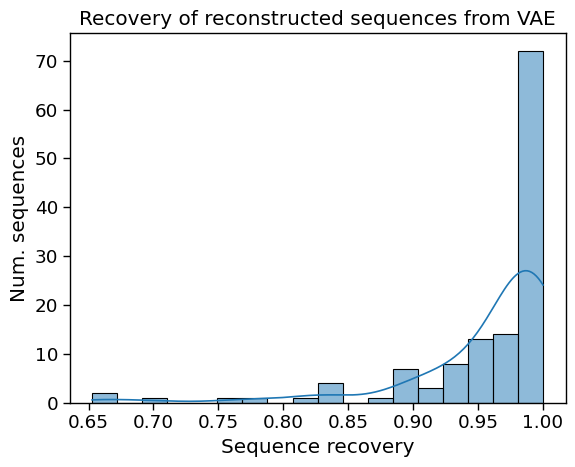

In [80]:
sns.histplot(scores, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title("Recovery of reconstructed sequences from VAE");

## Reconstruction of valid samples

In [86]:
valid_xb, _ = next(iter(dls.valid))
valid_xb.shape

torch.Size([256, 1, 288, 21])

In [87]:
# perform forward pass through model without computing gradients,
# retrieve the model's outputs
with torch.no_grad(): recon_valid,mu_valid,logvar_valid = to_cpu(model(valid_xb.cuda()))
recon_valid = recon_valid.float()

In [90]:
in_seqs = pd.Series([aaSeqLike(valid_xb[i].cpu().squeeze().detach().numpy(),
                               alphabet=STANDARD_AA) for i in range(xb.shape[0])])

# Convert logits to probabilities
recon_probs = F.softmax(recon_valid, dim=-1)

out_seqs = pd.Series([aaSeqLike(recon_probs[i].cpu().squeeze().detach().numpy(),
                                alphabet=STANDARD_AA) for i in range(recon_probs.shape[0])])

# Mean sequence recovery of a batch
scores = calc_recovery(in_seqs, out_seqs)
np.mean(scores)

0.9508192274305556

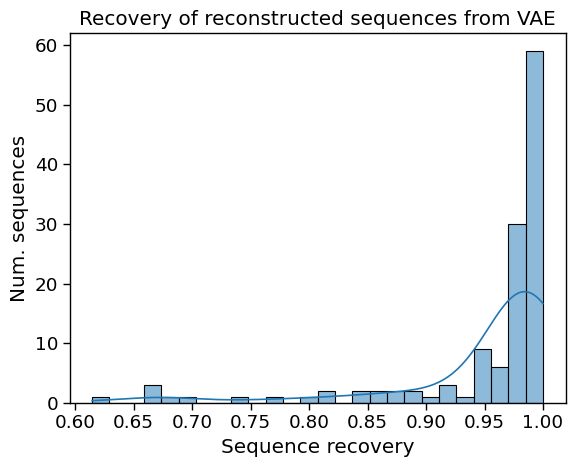

In [91]:
sns.histplot(scores, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title("Recovery of reconstructed sequences from VAE");

## Local Sampling

## Save model

In [81]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [82]:
torch.save(learn.model, mdl_path/'vae-dev.pkl')

In [83]:
#learn.model = torch.load(mdl_path/'vae-dev.pkl', map_location=torch.device('cpu'))
learn.model = torch.load(mdl_path/'vae-dev.pkl')

By virtue of its ability to capture the diversity of existing sequences directly, generative modeling has great
potential utility for engineering proteins with improved functional properties.

In [84]:
# Download final model from colab
!zip -r models/B5LY47-vae-model.zip models/

  adding: models/ (stored 0%)
  adding: models/vae-dev.pkl (deflated 8%)


In [85]:
# Download that zip file
from google.colab import files
files.download("models/B5LY47-vae-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>